# Language Detection

### Import Statements 

In [139]:
import os

import iso639 
import langid
import fasttext
import langdetect
import fasttext.util
from fasttext.FastText import _FastText


from iso639 import *
from langdetect import *
from sklearn.metrics import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from sentence_transformers import SentenceTransformer

le = LabelEncoder()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Useful Functions

- Text Cleaning

In [140]:
def clean(Text):
    """
    Clean text by removing newlines, tabs, and double spaces.

    Args:
        text (str or pandas.Series): Text data to clean. If a pandas Series is passed, 
            the cleaning is applied element-wise.

    Returns:
        str or pandas.Series: Cleaned text.

    """
    Text = Text.apply(lambda x: x.replace("\n", " "))
    Text = Text.apply(lambda x: x.replace("\t", " "))
    Text = Text.apply(lambda x: x.replace("  ", " "))
    return Text

- ISO Language Code to Language Name

In [141]:
def iso2str(text):
    '''
    Convert ISO language code to language name in string format.
    
    Args:
        text (str): ISO language code

    Returns:
        str: Language name in string format, or 'unknown' if the code is invalid.
    '''
    try:
        return languages.get(alpha2=text).name
    except:
        return 'unknown'

- LangDetect Prediction

In [142]:
def check_lang(text):
    '''Detects the language of the input text using Langdetect.
    
    Args:
        param text (str) : Input text
    Returns:
        str : Two-letter language code if language is detected, otherwise returns "unknown".
    '''
    try:
        lang = detect(str(text))
    except lang_detect_exception.LangDetectException:
        lang = 'unknown'
    return lang   

- FastText Prediction 

In [143]:
class LanguageIdentification:
    """
    A class for identifying the language of a given input text using a pre-trained fasttext language model.

    Attributes:
        model (fasttext.FastText._FastText): The pre-trained fasttext language model.

    Methods:
        predict_lang(text: str) -> str:
            Identifies the language of the given input text using the pre-trained fasttext language model.
    """

    def __init__(self):
        """
        Initializes the LanguageIdentification class by loading the pre-trained fasttext language model.
        """
        pretrained_lang_model = "../models/lid.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text: str) -> str:
        """
        Identifies the language of the given input text using the pre-trained fasttext language model.

        Args:
            text (str): The input text whose language is to be identified.

        Returns:
            str: The identified language of the input text.
        """
        predictions = self.model.predict(text, k=1) 
        predictions = predictions[0][0].replace("__label__", "")
        return predictions


- Custom Evaluation Report

In [144]:
def multiclass_report(y_true, y_pred, labels):
    '''
    Calculates and displays the accuracy, precision, and recall for the classification of a multiclass problem.

    Args:
        y_true (array-like): True labels for the data.
        y_pred (array-like): Predicted labels for the data.
        labels (list-like): List of unique class labels in the data.

    Returns:
        None

    Prints the accuracy, precision, and recall for the classification.
    Displays a confusion matrix as a heatmap.
    '''
    
    print(f'Accuracy: {np.mean(y_true == y_pred)}\nPrecision: {np.mean(y_true == y_pred)}\nRecall: {np.mean(y_true == y_pred)}')
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

- Embedding using SentenceTransformer 

In [145]:
st = SentenceTransformer('all-MiniLM-L6-v2')

def stEmbedding(text, model = 'model'):
    '''
    Embed the given text using Sentence Transformer.

    Args:
    - text (str): The text to embed.

    Returns:
    numpy.ndarray: The embedding of the input text as a numpy array.

    Raises:
    ValueError: If an unsupported model is specified.
    '''
    return st.encode(text)


- Embedding using FastText

In [146]:
ft = _FastText('../models/lid.bin')
def ftEmbedding(text):
    '''
    Embed the given text using a Fasttext.

    Args:
    - text (str): The text to embed.

    Returns:
    numpy.ndarray: The embedding of the input text as a numpy array.

    Raises:
    ValueError: If an unsupported model is specified.
    '''

    return ft.get_sentence_vector(text)

- T-Stocastic Neighbour Embedding Plot

In [147]:
def Tsen(Embedding, Language, Dimentions):
    '''
    Visualize word embeddings using t-SNE algorithm.

    Args:
        Embedding (pd.DataFrame): DataFrame containing word embeddings.
        Language (pd.Series): Series containing language labels for each word.
        Dimentions (int): Number of dimensions in the output embedding space.

    Returns:
        None

    Displays a scatter plot of the word embeddings in the reduced dimensional space.
    '''
    X = np.array(Embedding.tolist())
    y = Language.values
    X_embedded = TSNE(n_components=Dimentions).fit_transform(X)

    plt.figure(figsize=(10, 10))
    for i, lang in enumerate(Language.unique()):
        plt.scatter(X_embedded[y == lang, 0], X_embedded[y == lang, 1], label=lang)

    plt.legend()
    plt.show()

- Interactive Plot using Plotly 

In [189]:
def Plotly(Embedding, Language, Dimentions):
    '''
    Visualize word embeddings using t-SNE algorithm and Plotly library.

    Args:
        Embedding (pd.DataFrame): DataFrame containing word embeddings.
        Language (pd.Series): Series containing language labels for each word.
        Dimentions (int): Number of dimensions in the output embedding space.

    Returns:
        None

    Displays an interactive scatter plot of the word embeddings in the reduced dimensional space.
    '''
    # fig.update_layout(
    # autosize=False,
    # width=800,
    # # height=800,)
    
    X = np.array(Embedding.tolist())
    y = Language.values

    X_embedded = TSNE(n_components=Dimentions).fit_transform(X)
    fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=y, width=800, height=800)
    fig.show()

- Training Plots

In [149]:
def epoch(history, y_test, y_pred):
    '''
    Plot accuracy and loss values during training and validation as a function of epochs.

    Args:
        history (keras.callbacks.History): Object returned by fit() containing information about the training history.

    Returns:
        None

    Displays two plots:
    1. Accuracy vs Epochs: shows the training and validation accuracy values as a function of epochs.
    2. Loss vs Epochs: shows the training and validation loss values as a function of epochs.
    '''
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs Graph')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs Graph')
    plt.legend()
    plt.show()




In [150]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def modelEval(y_test, y_pred):
    """
    Evaluate the model performance using various metrics and plot a confusion matrix.

    Args:
        y_test (numpy array): True labels of the test data in one-hot encoding format
        y_pred (numpy array): Predicted labels of the test data in categorical format

    Returns:
        None
    """
    model.summary()
    print()

    y_test = np.argmax(y_test, axis=1)

    xtick = df['Language'].unique()
    ytick = df['Language'].unique()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'Accuracy\t:\t{accuracy}')
    print(f'Precision\t:\t{precision}')
    print(f'Recall\t:\t{recall}')
    print(f'F1 score\t:\t{f1}')

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=xtick, yticklabels=ytick)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


- Data Splitting Function 

In [151]:
from keras.utils import to_categorical

def split_train_test_data(Embedding, Language):
    '''
    Splits the data into training and testing sets, and applies label encoding to the target variable.

    Args:
    - Embedding (DataFrame): DataFrame containing the embedding vectors.
    - Language (DataFrame): DataFrame containing the target variable.

    Returns:
    - X_train, X_test, y_train, y_test (numpy.ndarray): The training and testing data and target variables.
    '''
    
    X = np.array(Embedding.tolist())

    y = Language.values
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

- All in One Wrapper for creating Custom model _(OLD)_ 

In [152]:
from tensorflow.keras.models import Sequential

def createModel(model_type, num_layers, layer_types, layer_units, input_shape, output_units):
    '''Create a deep learning model with specified architecture.

    Args:
        model_type (str): The type of model to create. Supported values are
            'Sequentials', 'LSTM', and 'Convolutional'.
        num_layers (int): The number of layers to include in the model.
        layer_types (list[str]): A list of layer types to include in the model.
        layer_units (list[int]): A list of the number of units for each layer in the model.
        input_shape (tuple[int]): The shape of the input data.
        output_units (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported model type is specified.
    '''

    if model_type == 'Sequentials':
        model = Sequential()
        for i in range(num_layers):
            if layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")
    elif model_type == 'LSTM':
        model = Sequential()
        for i in range(num_layers):
            if layer_types[i] == 'LSTM':
                model.add(LSTM(layer_units[i], input_shape=inputLayer, return_sequences=True))
            elif layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")
        model.add(Dense(output_units, activation='softmax'))
    elif model_type == 'Convolutional':
        model = Sequential()
        for i in range(num_layers):
            if layer_types[i] == 'Conv1D':
                model.add(Conv1D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=inputLayer))
            elif layer_types[i] == 'MaxPooling1D':
                model.add(MaxPooling1D(pool_size=2))
            elif layer_types[i] == 'Conv2D':
                model.add(Conv2D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=inputLayer))
            elif layer_types[i] == 'MaxPooling2D':
                model.add(MaxPooling2D(pool_size=2))
            elif layer_types[i] == 'Flatten':
                model.add(Flatten())
            elif layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")
        model.add(Dense(output_units, activation='softmax'))
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
    
    return model


In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def sequentialModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with Sequenctial architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layerTypes[i] == 'Dense':
            model.add(Dense(layerUnits[i], activation='relu'))
        elif layerTypes[i] == 'Dropout':
            model.add(Dropout(layerUnits[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def LSTMModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with LSTM architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layerTypes[i] == 'LSTM':
            model.add(LSTM(layerUnits[i], input_shape=inputLayer, return_sequences=True))
        elif layerTypes[i] == 'Dense':
            model.add(Dense(layerUnits[i], activation='relu'))
        elif layerTypes[i] == 'Dropout':
            model.add(Dropout(layerUnits[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [155]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def ConvoModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with Convolutional architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layerTypes[i] == 'Conv1D':
            model.add(Conv1D(filters=layerUnits[i], kernel_size=3, activation='relu', input_shape=inputLayer))
        elif layerTypes[i] == 'MaxPooling1D':
            model.add(MaxPooling1D(pool_size=2))
        elif layerTypes[i] == 'Conv2D':
            model.add(Conv2D(filters=layerUnits[i], kernel_size=3, activation='relu', input_shape=inputLayer))
        elif layerTypes[i] == 'MaxPooling2D':
            model.add(MaxPooling2D(pool_size=2))
        elif layerTypes[i] == 'Flatten':
            model.add(Flatten())
        elif layerTypes[i] == 'Dense':
            model.add(Dense(layerUnits[i], activation='relu'))
        elif layerTypes[i] == 'Dropout':
            model.add(Dropout(layerUnits[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

In [181]:
def TrainModel(model, epochs, name, X_train, X_test, y_train, y_test):
    '''
    Train the deep learning model and evaluate its performance

    Args:
    - model : the deep learning model object
    - epochs : the number of epochs to train the model
    - name : the name of the file to save the trained model
    - X_train : the input training data
    - X_test : the input testing data
    - y_train : the target training labels
    - y_test : the target testing labels

    Returns:
    None
    '''

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
    # model.summary()
    model.save(f"../models/{name}")
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred, history


## Using Pre-built Libraries

In [157]:
df = pd.read_csv('../data/Language.csv')
df.head()

Text Language
0   Nature, in the broadest sense, is the natural...  English
1  "Nature" can refer to the phenomena of the phy...  English
2  The study of nature is a large, if not the onl...  English
3  Although humans are part of nature, human acti...  English
4  [1] The word nature is borrowed from the Old F...  English

- LangDetect


Using Langdetect
Accuracy: 0.7894940504982103
Precision: 0.7894940504982103
Recall: 0.7894940504982103


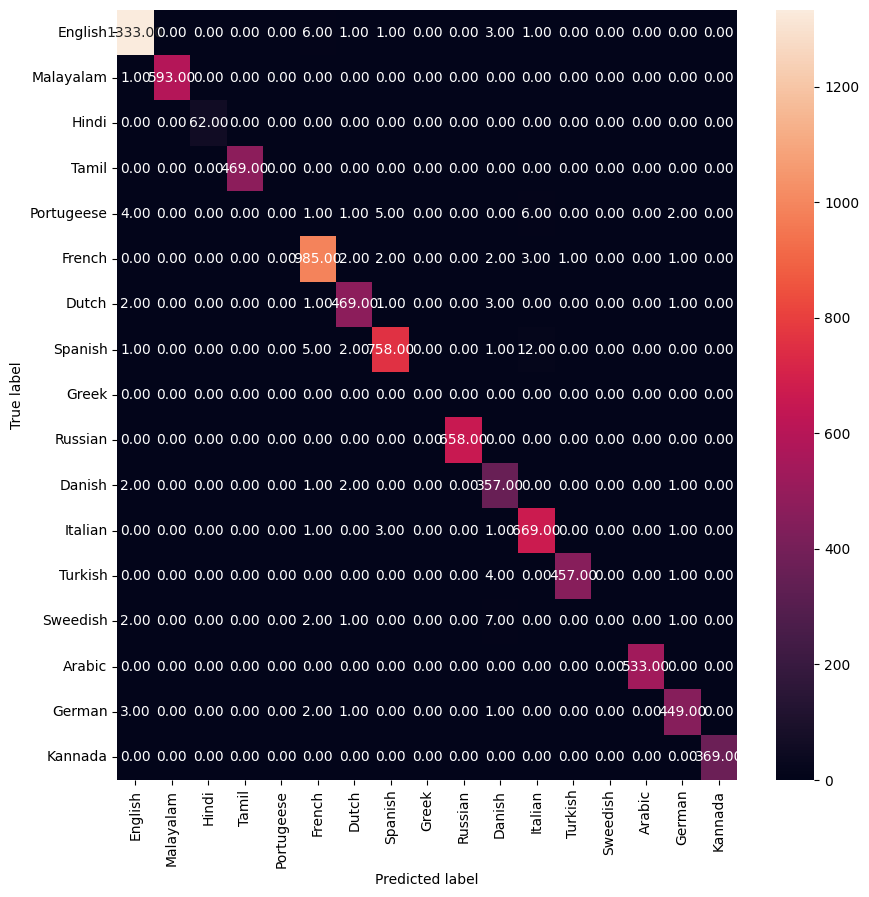

In [158]:
print("Using Langdetect")
df['langdetect'] = df['Text'].apply(check_lang)
df['langdetect'] = df['langdetect'].apply(iso2str)
multiclass_report(df['Language'], df['langdetect'], df['Language'].unique())


- LangId


Using Langid
Accuracy: 0.7907516687626971
Precision: 0.7907516687626971
Recall: 0.7907516687626971


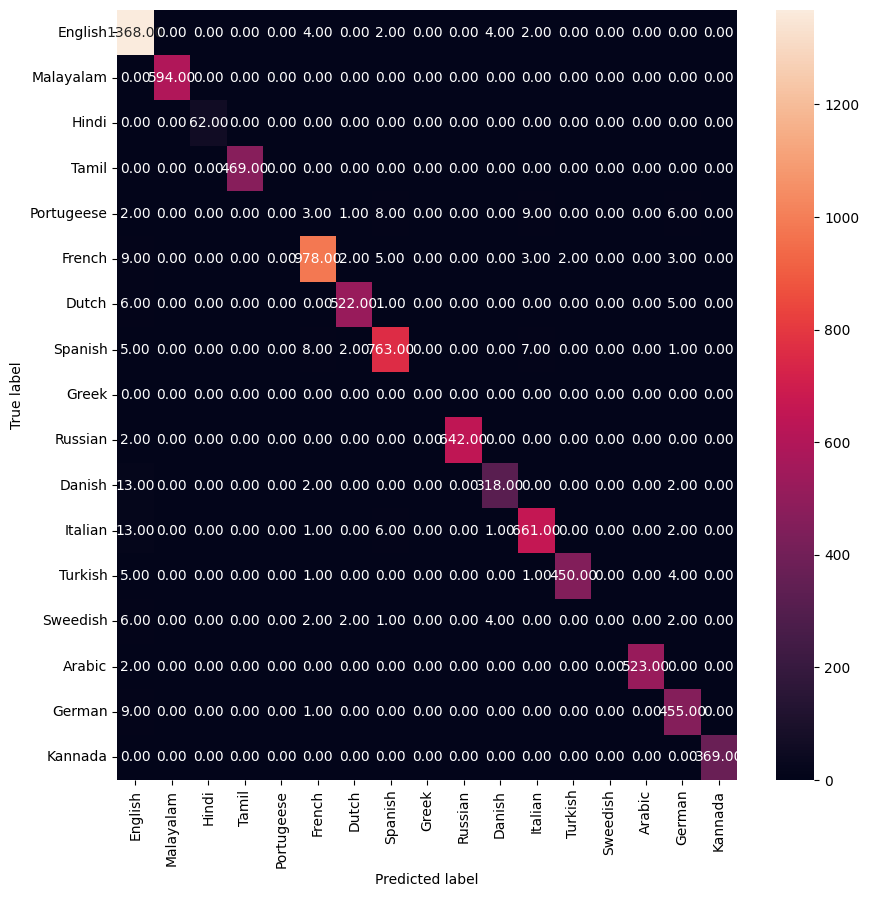

In [159]:
print("Using Langid")
df['langid'] = df['Text'].apply(langid.classify)
df['langid'] = df['langid'].apply(lambda x: x[0])
df['langid'] = df['langid'].apply(iso2str)
multiclass_report(df['Language'], df['langid'], df['Language'].unique())

- FastText

Using Fasttext
Accuracy: 0.8179355712489117
Precision: 0.8179355712489117
Recall: 0.8179355712489117


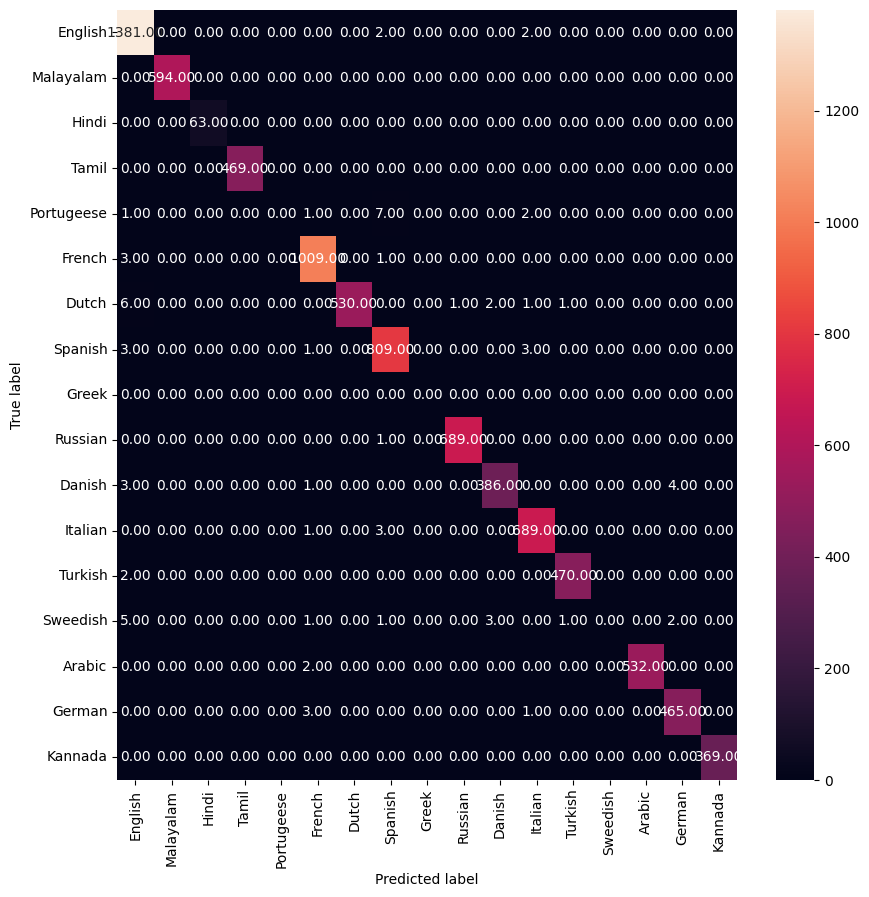

In [160]:
model = LanguageIdentification()

print("Using Fasttext")
df['Text'] = df['Text'].apply(lambda x: x.replace("\n", " "))
df['fasttext'] = df['Text'].apply(model.predict_lang)
df['fasttext'] = df['fasttext'].apply(iso2str)
multiclass_report(df['Language'], df['fasttext'], df['Language'].unique())

## Using Embeddings

In [161]:
df = pd.read_csv('../data/Language.csv')
df['Text'] = clean(df['Text'])

df['Embedding'] = df['Text'].apply(stEmbedding)


In [162]:
df.head()

Text Language   
0   Nature, in the broadest sense, is the natural...  English  \
1  "Nature" can refer to the phenomena of the phy...  English   
2  The study of nature is a large, if not the onl...  English   
3  Although humans are part of nature, human acti...  English   
4  [1] The word nature is borrowed from the Old F...  English   

                                           Embedding  
0  [0.0638107, -0.02032167, 0.022865308, 0.080334...  
1  [0.04028565, 0.01301233, 0.010959733, 0.138003...  
2  [0.07350297, 0.06153041, 0.08317, 0.07226973, ...  
3  [0.04971937, -0.046503335, 0.06687324, 0.04738...  
4  [0.026049452, 0.031227026, 0.010860803, 0.1173...

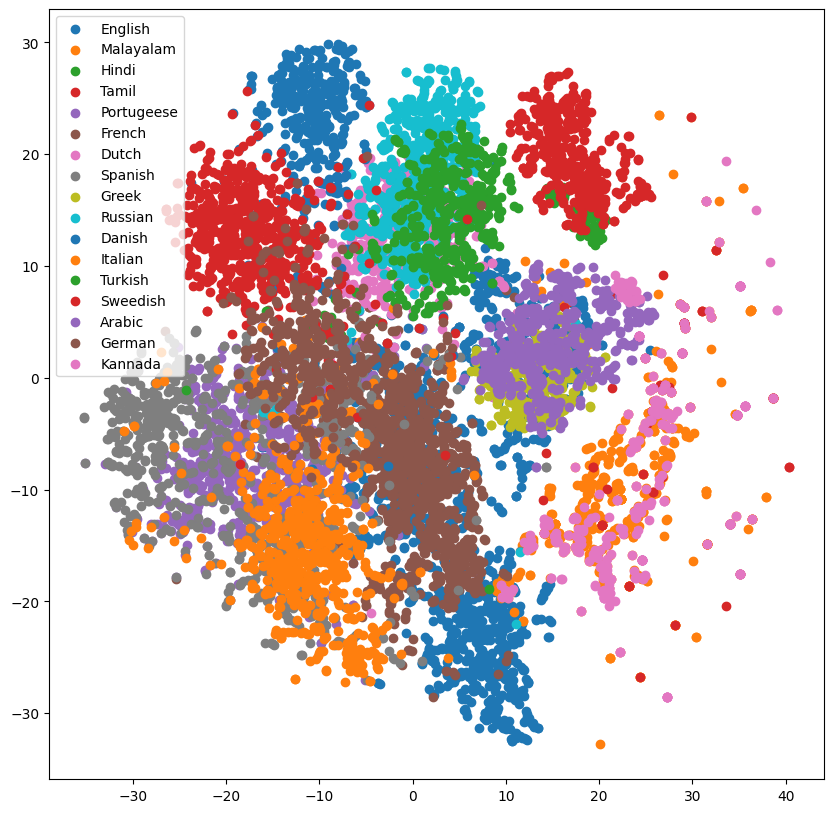

In [163]:
Tsen(df['Embedding'], df['Language'], 3)

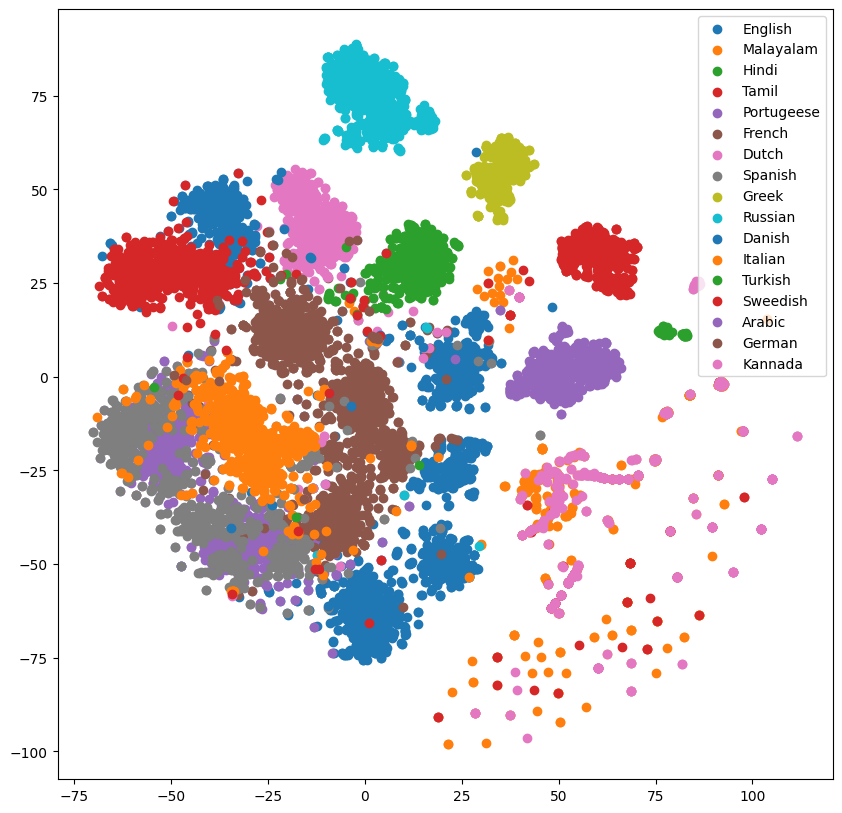

In [164]:
Tsen(df['Embedding'], df['Language'], 2)

In [165]:
Plotly(df['Embedding'], df['Language'], 3)

In [166]:
Plotly(df['Embedding'], df['Language'], 2)

In [167]:
X_train, X_test, y_train, y_test = split_train_test_data(df['Embedding'], df['Language'])

In [168]:
model = sequentialModel(numLayers=3, layerTypes=['Dense', 'Dropout', 'Dense'], layerUnits=[32, 0.3, 128], inputLayer=(None, 384), outputLayer=17)
y_pred, history = TrainModel(model, 10, 'sequentialModel', X_train, X_test, y_train, y_test)

Epoch 1/10
259/259 [==============================] - 1s 3ms/step - loss: 1.4991 - accuracy: 0.5530 - val_loss: 0.5393 - val_accuracy: 0.8279
Epoch 2/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5603 - accuracy: 0.8095 - val_loss: 0.3493 - val_accuracy: 0.8902
Epoch 3/10
259/259 [==============================] - 0s 2ms/step - loss: 0.4167 - accuracy: 0.8549 - val_loss: 0.2798 - val_accuracy: 0.9043
Epoch 4/10
259/259 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8817 - val_loss: 0.2473 - val_accuracy: 0.9115
Epoch 5/10
259/259 [==============================] - 0s 2ms/step - loss: 0.2989 - accuracy: 0.8930 - val_loss: 0.2296 - val_accuracy: 0.9144
Epoch 6/10
259/259 [==============================] - 0s 2ms/step - loss: 0.2714 - accuracy: 0.8991 - val_loss: 0.2200 - val_accuracy: 0.9159
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.9047 - val_loss: 0.2110 - val_accuracy: 0.9207
Epoch 

2023-05-02 16:06:04.946643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-02 16:06:05.097785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ../models/sequentialModel/assets


INFO:tensorflow:Assets written to: ../models/sequentialModel/assets


65/65 [==============================] - 0s 1ms/step


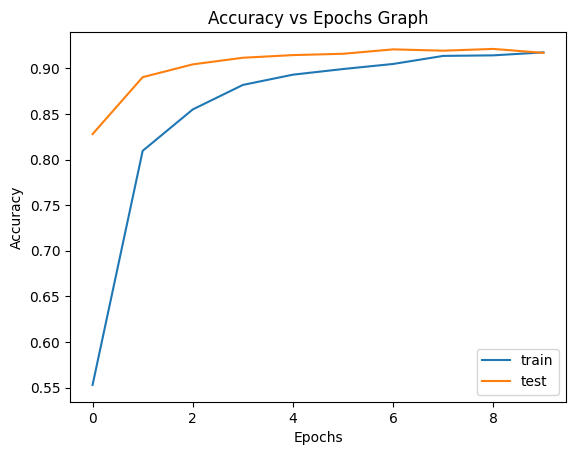

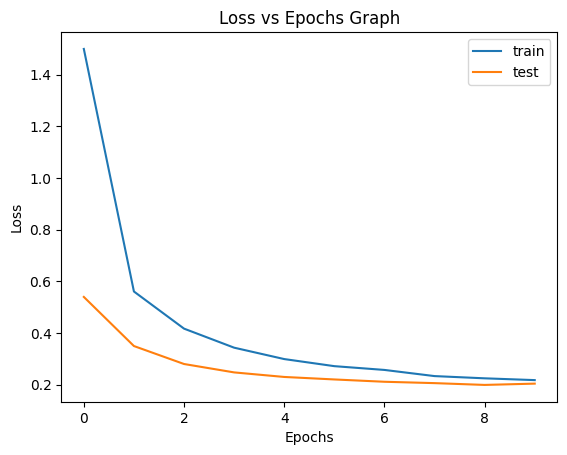

In [169]:
epoch(history, y_test, y_pred)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                12320     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 128)               4224      
                                                                 
 dense_30 (Dense)            (None, 17)                2193      
                                                                 
Total params: 18,737
Trainable params: 18,737
Non-trainable params: 0
_________________________________________________________________

Accuracy	:	0.9168278529980658
Precision	:	0.9187077093512849
Recall	:	0.9168278529980658
F1 score	:	0.9170024078038358


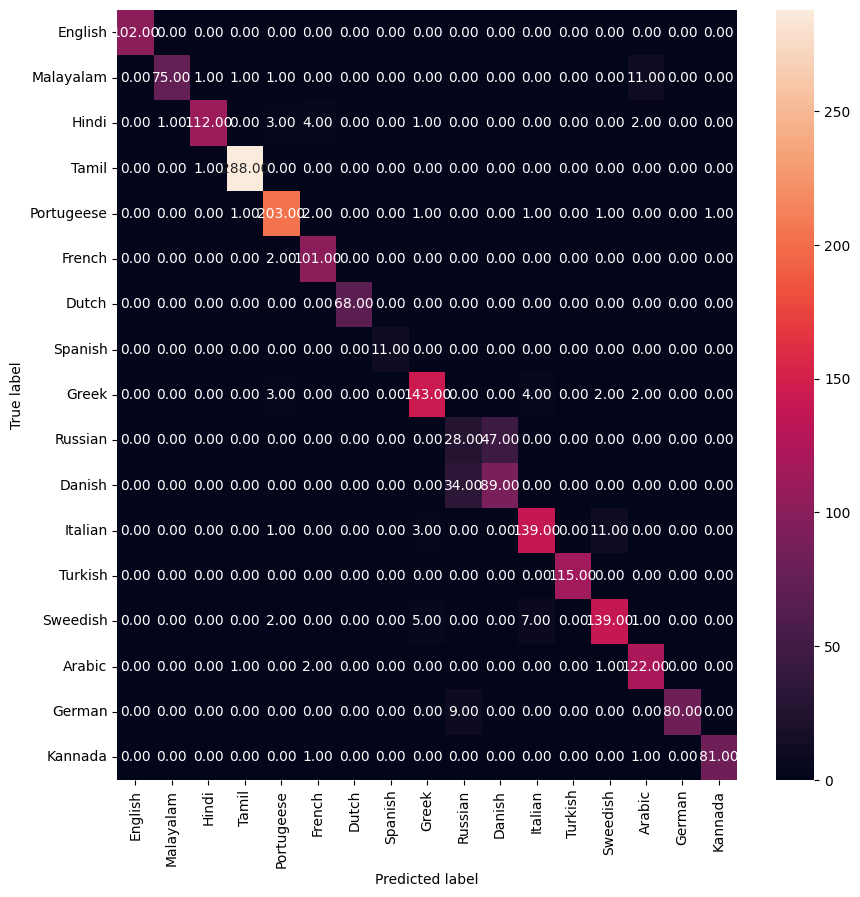

In [170]:
modelEval(y_test, y_pred)


In [171]:
df = pd.read_csv('../data/Language.csv')
df['Text'] = clean(df['Text'])


df['Embedding'] = df['Text'].apply(ftEmbedding)

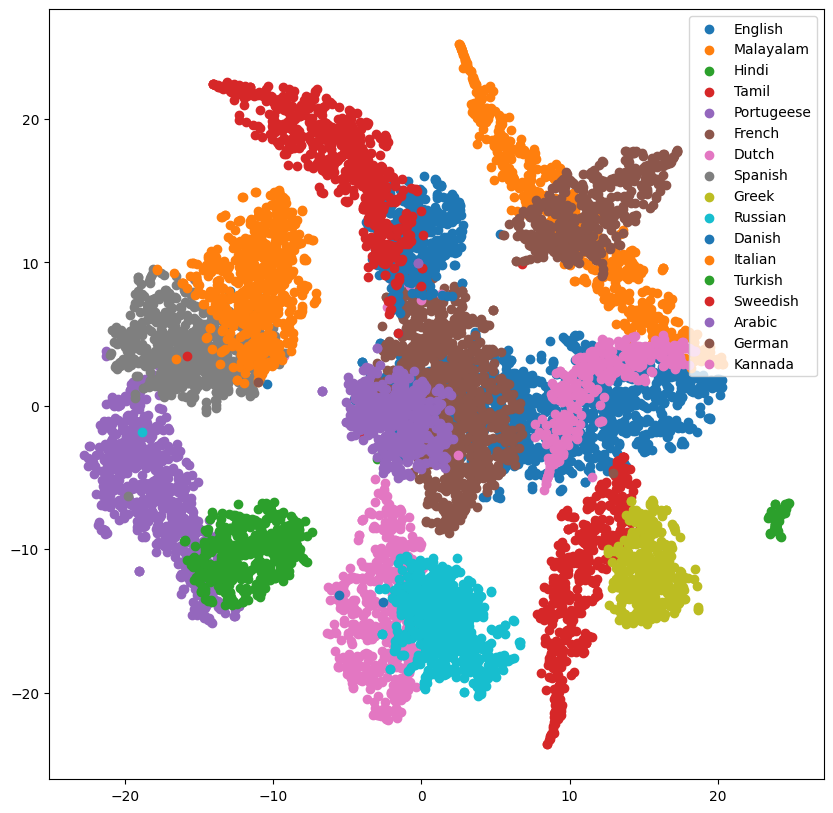

In [172]:
Tsen(df['Embedding'], df['Language'], 3)

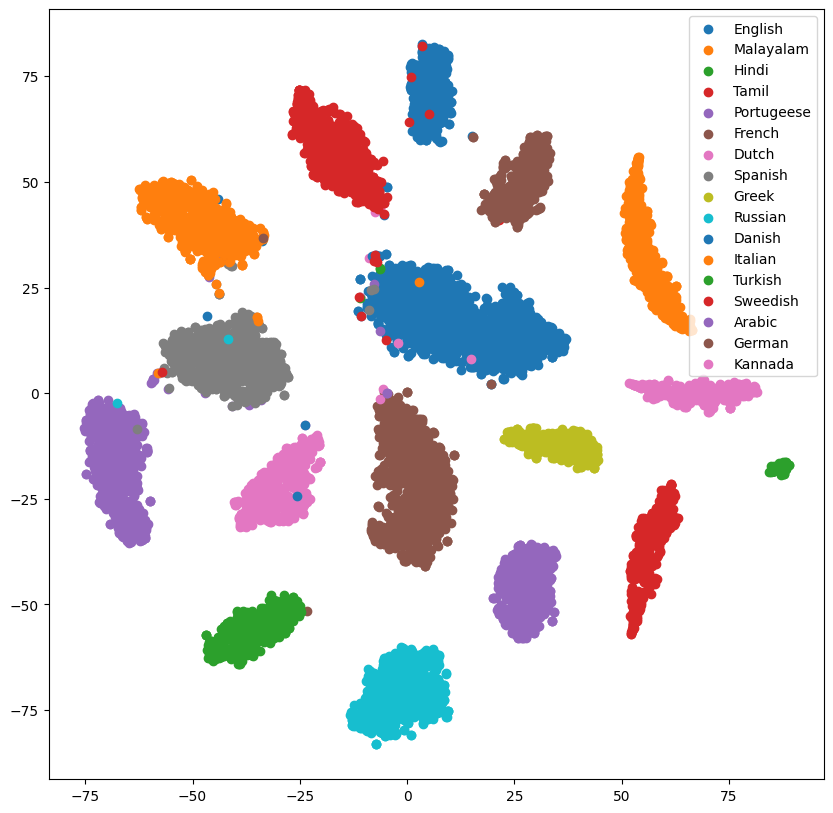

In [173]:
Tsen(df['Embedding'], df['Language'], 2)

In [190]:
Plotly(df['Embedding'], df['Language'], 3)

In [191]:
Plotly(df['Embedding'], df['Language'], 2)

In [176]:
X_train, X_test, y_train, y_test = split_train_test_data(df['Embedding'], df['Language'])

In [182]:
model = sequentialModel(numLayers=3, layerTypes=['Dense', 'Dropout', 'Dense'], layerUnits=[32, 0.3, 128], inputLayer=(None, 384), outputLayer=17)
y_pred, history = TrainModel(model, 10, 'sequentialModel', X_train, X_test, y_train, y_test)

Epoch 1/10
259/259 [==============================] - 1s 2ms/step - loss: 1.0870 - accuracy: 0.8325 - val_loss: 0.0857 - val_accuracy: 0.9913
Epoch 2/10
259/259 [==============================] - 0s 1ms/step - loss: 0.1414 - accuracy: 0.9730 - val_loss: 0.0368 - val_accuracy: 0.9923
Epoch 3/10
259/259 [==============================] - 0s 1ms/step - loss: 0.0853 - accuracy: 0.9817 - val_loss: 0.0302 - val_accuracy: 0.9923
Epoch 4/10
259/259 [==============================] - 0s 1ms/step - loss: 0.0706 - accuracy: 0.9842 - val_loss: 0.0284 - val_accuracy: 0.9927
Epoch 5/10
259/259 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.9831 - val_loss: 0.0258 - val_accuracy: 0.9927
Epoch 6/10
259/259 [==============================] - 0s 1ms/step - loss: 0.0601 - accuracy: 0.9851 - val_loss: 0.0244 - val_accuracy: 0.9947
Epoch 7/10
259/259 [==============================] - 0s 1ms/step - loss: 0.0533 - accuracy: 0.9872 - val_loss: 0.0241 - val_accuracy: 0.9942
Epoch 

2023-05-02 16:20:27.731277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-02 16:20:27.839873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ../models/sequentialModel/assets


INFO:tensorflow:Assets written to: ../models/sequentialModel/assets


65/65 [==============================] - 0s 2ms/step


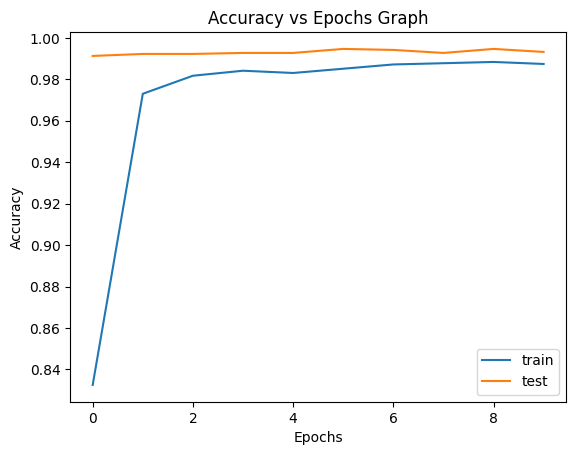

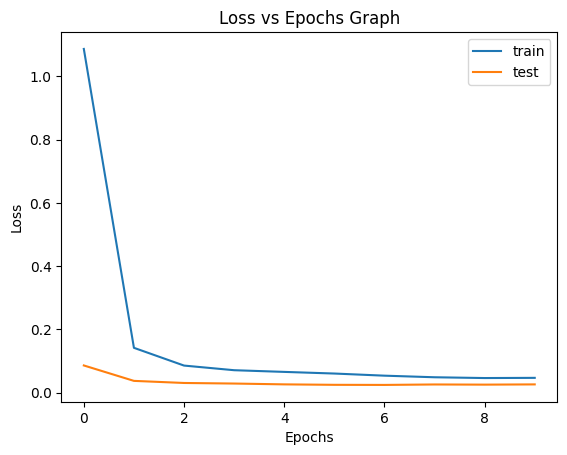

In [183]:
epoch(history, y_test, y_pred)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 32)                544       
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 128)               4224      
                                                                 
 dense_39 (Dense)            (None, 17)                2193      
                                                                 
Total params: 6,961
Trainable params: 6,961
Non-trainable params: 0
_________________________________________________________________

Accuracy	:	0.9932301740812379
Precision	:	0.9932750838032414
Recall	:	0.9932301740812379
F1 score	:	0.993230644330782


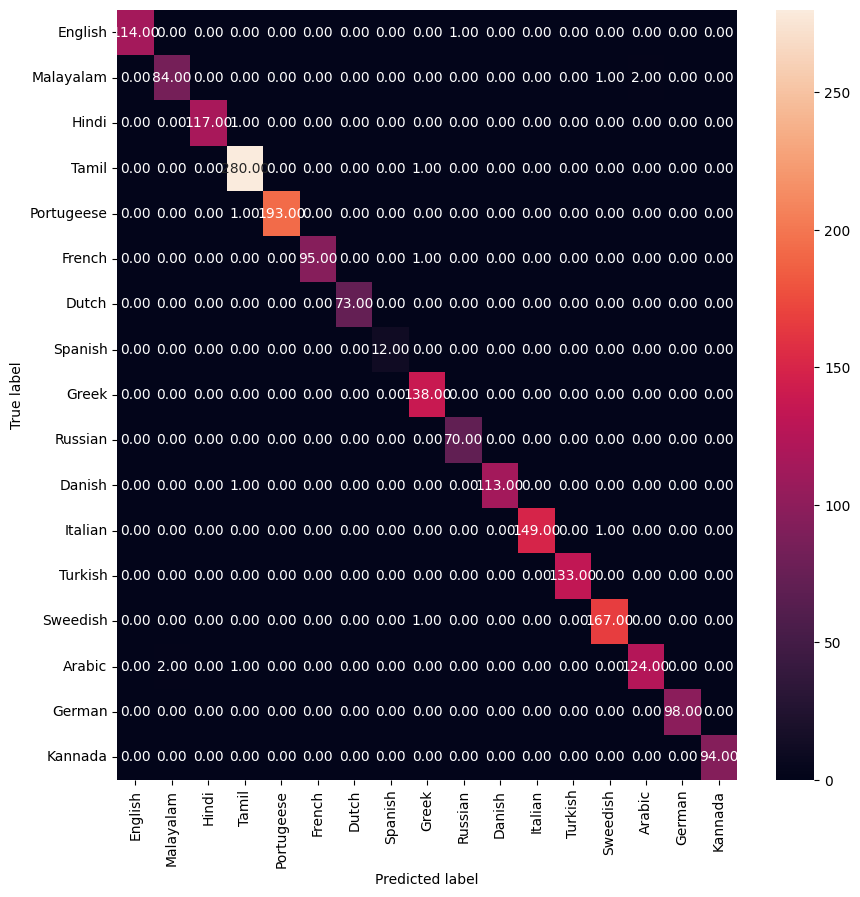

In [184]:
modelEval(y_test, y_pred)
